# Import needed modules and useful functions

In [1]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "multi_t/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

# Define Bias
ecv: ECV_MULTITHERMAL ARG=ene TEMP_MAX=600 
opes: OPES_EXPANDED ARG=ecv.* PACE=500 FILE=KERNELS RESTART=NO STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data angles/run_gromacs.sh "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

Completed: cp script/input.* script/plumed_descriptors.data angles/run_gromacs.sh multi_t/
Completed: ./run_gromacs.sh


Text(0, 0.5, '$\\psi$')

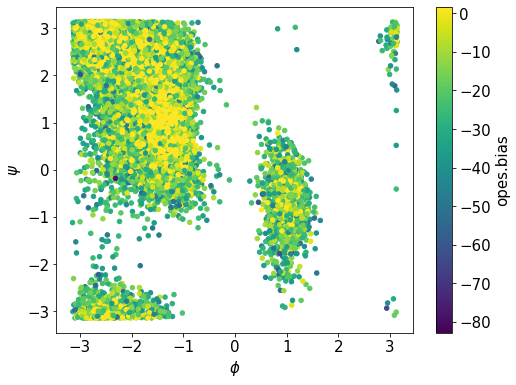

In [4]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",c="opes.bias",cmap="viridis",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

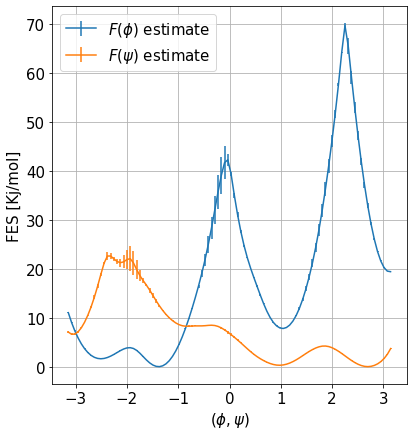

In [5]:
#-- estimation of Free Energy Surface --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
data = load_dataframe(folder+"COLVAR")
logweight=( data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) )*sim_parameters["beta"]

''' questo riscalamento che uso non dà una stima vera delle free energy. Infatti è come se cambiassi la temperatura
    e ottengo qualcosa molto simile a non usare i pesi, cioè stime di una simulazione unbias come se non l'avessi nemmeno biasiata
logweight=( data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy()) )
logweight /= np.abs(np.min(logweight))
logweight *= sim_parameters["beta"]
'''

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend([r"$F(\phi)$ estimate",r"$F(\psi)$ estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(\phi,\psi)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

<AxesSubplot:xlabel='time', ylabel='opes.bias'>

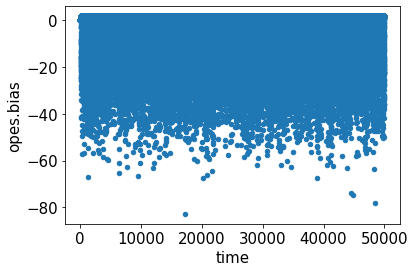

In [6]:
#data["opes.bias"] -= np.max(data["opes.bias"])
data[:].plot.scatter(x="time",y="opes.bias")

In [7]:
#data = load_dataframe(folder+"COLVAR")
#data = data[data["time"]>20000]

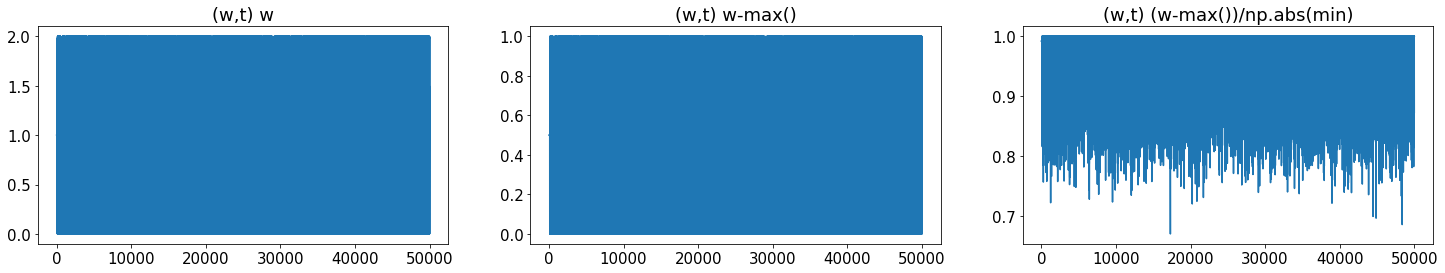

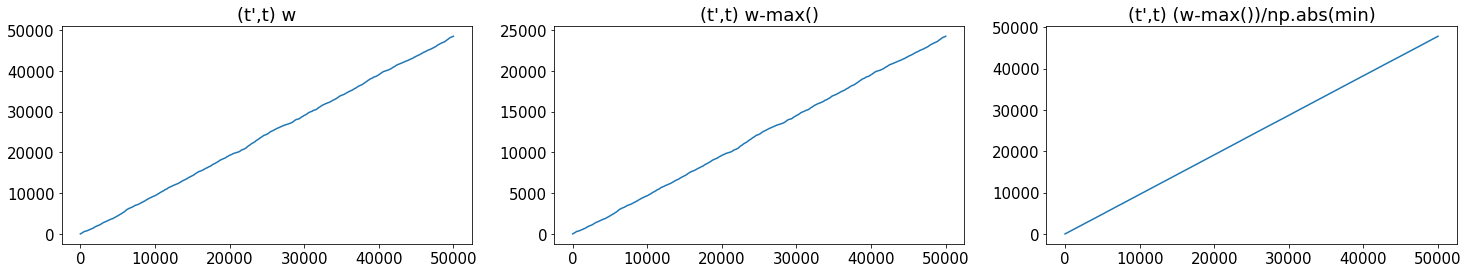

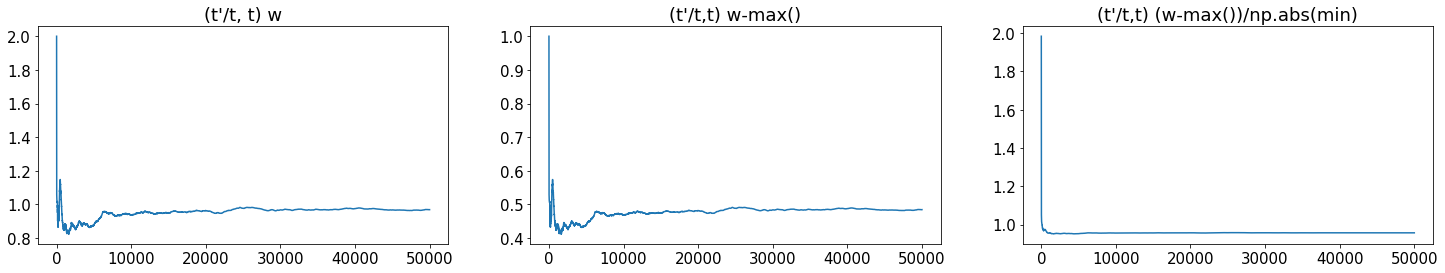

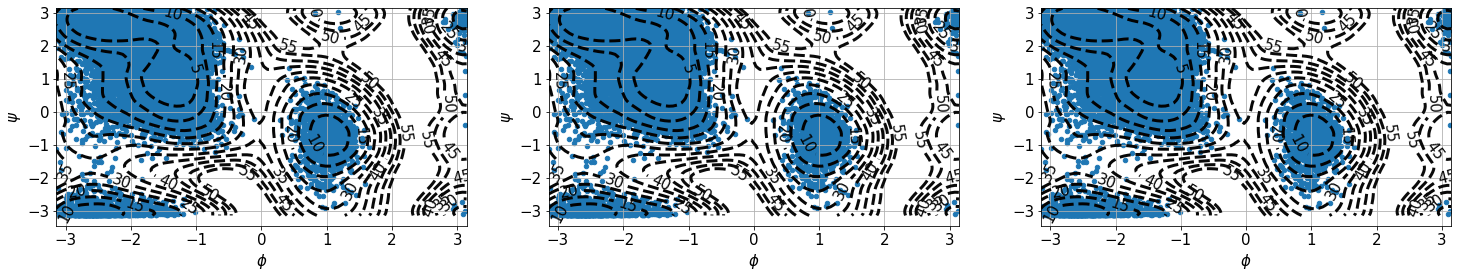

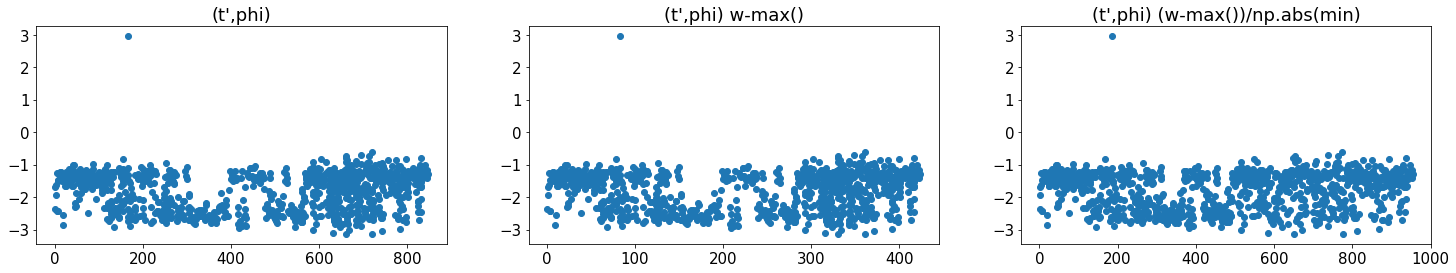

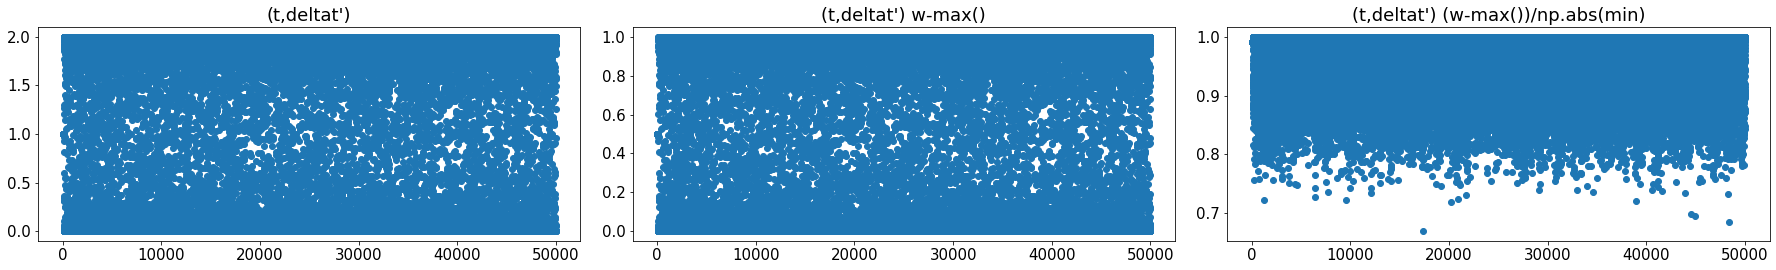

In [8]:
#''' compare different set up for rescaled time
fig,axs1 = plt.subplots(1,3,figsize=(25,4))
fig,axs2 = plt.subplots(1,3,figsize=(25,4))
fig,axs3 = plt.subplots(1,3,figsize=(25,4))
fig,axs4 = plt.subplots(1,3,figsize=(25,4))
fig,axs5 = plt.subplots(1,3,figsize=(25,4))
fig,axs6 = plt.subplots(1,3,figsize=(25,4))
    
X = data.filter(regex='^d[^a-z]').values
# rescaled as must be
logweight = data["opes.bias"].to_numpy()*sim_parameters["beta"]
t = data['time'].values
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
axs1[0].plot(t,np.exp(logweight))
axs1[0].set_title("(w,t) w")
axs2[0].plot(t,tprime)
axs2[0].set_title("(t',t) w")
axs3[0].plot(t[1:],tprime[1:]/t[1:])
axs3[0].set_title("(t'/t, t) w")
axs5[0].scatter(tprime[:1000],data["phi"].to_numpy()[:1000])
axs5[0].set_title("(t',phi)")
deltatprime = [tprime[i+1]-tprime[i] for i in range(len(tprime)-1)]
axs6[0].scatter(t[1:],deltatprime)
axs6[0].set_title("(t,deltat')")
# rescaled as Michele wants
logweight -= max(logweight)
tprime = dt * np.cumsum(np.exp(logweight))
axs1[1].plot(t,np.exp(logweight))
axs1[1].set_title("(w,t) w-max()")
axs2[1].plot(t,tprime)
axs2[1].set_title("(t',t) w-max()")
axs3[1].plot(t[1:],tprime[1:]/t[1:])
axs3[1].set_title("(t'/t,t) w-max()")
axs5[1].scatter(tprime[:1000],data["phi"].to_numpy()[:1000])
axs5[1].set_title("(t',phi) w-max()")
deltatprime = [tprime[i+1]-tprime[i] for i in range(len(tprime)-1)]
axs6[1].scatter(t[1:],deltatprime)
axs6[1].set_title("(t,deltat') w-max()")
# rescaled as I want
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
logweight /= np.abs(np.min(logweight))
logweight *= sim_parameters["beta"]
tprime = dt * np.cumsum(np.exp(logweight))
axs1[2].plot(t,np.exp(logweight))
axs1[2].set_title("(w,t) (w-max())/np.abs(min)")
axs2[2].plot(t,tprime)
axs2[2].set_title("(t',t) (w-max())/np.abs(min)")
axs3[2].plot(t[1:],tprime[1:]/t[1:])
axs3[2].set_title("(t'/t,t) (w-max())/np.abs(min)")
axs5[2].scatter(tprime[:1000],data["phi"].to_numpy()[:1000])
axs5[2].set_title("(t',phi) (w-max())/np.abs(min)")
deltatprime = [tprime[i+1]-tprime[i] for i in range(len(tprime)-1)]
axs6[2].scatter(t[1:],deltatprime)
axs6[2].set_title("(t,deltat') (w-max())/np.abs(min)")
#-- trajectories in phi / psi --#

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
for i in range(3):
    data.plot.scatter(y="psi",x="phi",ax=axs4[i])
    c = axs4[i].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c.clabel()
    axs4[i].grid()
    axs4[i].set_xlabel(r"$\phi$")
    axs4[i].set_ylabel(r"$\psi$")
plt.tight_layout()

In [9]:
'''
fig,axs1 = plt.subplots(1,3,figsize=(20,4))
data = load_dataframe(folder+"COLVAR")
t = data['time'].values
X = data.filter(regex='^d[^a-z]').values
logweight = data["opes.bias"].to_numpy()*sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
x = data["phi"].values
#-- without minus max --#
autocorr = np.empty(0)
N = 100
lags = np.linspace(0,10,N)
for lag in lags:
    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)
    autocorr = np.append(autocorr,res)
axs1[0].plot(lags,autocorr)
axs1[0].set_title("(t,w)")
#-- with minus max --#
autocorr = np.empty(0)
logweight -= max(logweight)
tprime = dt * np.cumsum(np.exp(logweight))
for lag in lags:
    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)
    autocorr = np.append(autocorr,res)
axs1[1].plot(lags,autocorr)
axs1[1].set_title("(t,w) w-max() ")
#-- with minus max and / np.abs(min)--#
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
logweight /= np.abs(np.min(logweight))
autocorr = np.empty(0)
logweight *= sim_parameters["beta"]
tprime = dt * np.cumsum(np.exp(logweight))
for lag in lags:
    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)
    autocorr = np.append(autocorr,res)
axs1[2].plot(lags,autocorr)
axs1[2].set_title("(t,w) (w-max())/np.abs(min)")
'''

'\nfig,axs1 = plt.subplots(1,3,figsize=(20,4))\ndata = load_dataframe(folder+"COLVAR")\nt = data[\'time\'].values\nX = data.filter(regex=\'^d[^a-z]\').values\nlogweight = data["opes.bias"].to_numpy()*sim_parameters["beta"]\ndt = t[1]-t[0]\ntprime = dt * np.cumsum(np.exp(logweight))\nx = data["phi"].values\n#-- without minus max --#\nautocorr = np.empty(0)\nN = 100\nlags = np.linspace(0,10,N)\nfor lag in lags:\n    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)\n    autocorr = np.append(autocorr,res)\naxs1[0].plot(lags,autocorr)\naxs1[0].set_title("(t,w)")\n#-- with minus max --#\nautocorr = np.empty(0)\nlogweight -= max(logweight)\ntprime = dt * np.cumsum(np.exp(logweight))\nfor lag in lags:\n    res = my_autocorrelation_python(x,lag=lag,weight=np.exp(logweight),time=t, tprime=tprime)\n    autocorr = np.append(autocorr,res)\naxs1[1].plot(lags,autocorr)\naxs1[1].set_title("(t,w) w-max() ")\n#-- with minus max and / np.abs(min)--#\nlogweight = d

In [10]:
''' 2d fes estimation
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 4)#, figure=fig)

ax_scatter = fig.add_subplot(gs[1:4,0:3])
ax_hist_x = fig.add_subplot(gs[0,:3])
ax_hist_y = fig.add_subplot(gs[1:,3])

#-- 2D plot --#
fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
bounds = np.arange(0, 60, 5.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
)
c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
#fig.colorbar(c, ax=ax_scatter,label="FES [KbT]")
c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
ax_scatter.legend(["FES [Kj/mol]"])
c.clabel()
ax_scatter.grid()
ax_scatter.set_xlabel(r"$\phi$")
ax_scatter.set_ylabel(r"$\psi$")
np.savetxt(folder+"fes.txt",fes,delimiter=" ")
np.savetxt(folder+"grid0.txt",grid[0],delimiter=" ")
np.savetxt(folder+"grid1.txt",grid[1],delimiter=" ")

#-- 1D plot --#
fes,grid,bounds,error = compute_fes(s[:,0], weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')

np.savetxt(folder+"fes1dphi.txt",fes,delimiter=" ")
np.savetxt(folder+"grid1dphi.txt",grid,delimiter=" ")
np.savetxt(folder+"err1dphi.txt",error,delimiter=" ")

ax_hist_x.errorbar(grid,fes,yerr=error)
ax_hist_x.set_ylabel("FES [Kj/mol]")
ax_hist_x.grid()
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_y)
fes,grid,bounds,error = compute_fes(s[:,1], weights=np.exp(logweight),
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_hist_x)
np.savetxt(folder+"fes1dpsi.txt",fes,delimiter=" ")
np.savetxt(folder+"grid1dpsi.txt",grid,delimiter=" ")
np.savetxt(folder+"err1dpsi.txt",error,delimiter=" ")

ax_hist_y.errorbar(fes,grid,xerr=error)
ax_hist_y.set_xlabel("FES [Kj/mol]")
ax_hist_y.grid()

plt.tight_layout()
plt.show()
'''

' 2d fes estimation\ns = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()\nlogweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]*sim_parameters["beta"]\n\nfig = plt.figure(figsize=(10,10))\ngs = GridSpec(4, 4)#, figure=fig)\n\nax_scatter = fig.add_subplot(gs[1:4,0:3])\nax_hist_x = fig.add_subplot(gs[0,:3])\nax_hist_y = fig.add_subplot(gs[1:,3])\n\n#-- 2D plot --#\nfes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),\n                                    temp=sim_parameters["temp"],\n                                    kbt=sim_parameters["kbt"],\n                                    blocks=sim_parameters["blocks"],\n                                    bandwidth=sim_parameters["bandwidth"],scale_by=\'range\')\n                                    #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)\nbounds = np.arange(0, 60, 5.)\ncmap = plt.cm.get_cmap(\'fessa\',len(bounds))\ncolors = list(cmap(np

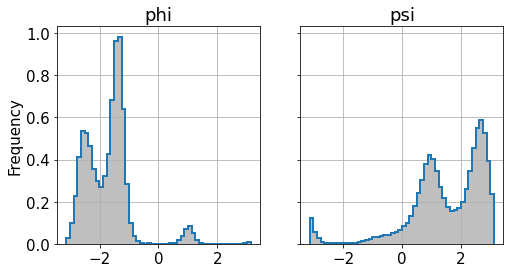

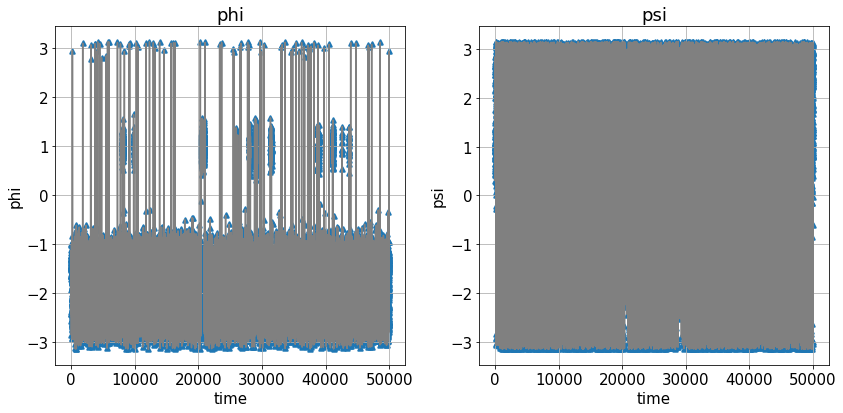

In [11]:
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::1].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::1].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

## Deep TICA Analysis  
Qui analizzo con la Deeptica la simulazione biased.  
Lo farò utilizzando 4 diversi tprime per il tempo riscalato: 
1. senza usare il tempo riscalato 
2. usando il vero e proprio tempo riscalato con tprime = dt * exp(beta*logweights)
3. come farebbe michele con tprime = dt * exp(beta*logweights-max(beta*logweights))
4. come farei io con logweights -= max(logweights); logweights /= np.abs(np.min(logweights)); logweights \*= beta, tprime = dt * exp(logweights)

Results: 
Per tempi molti grandi nessuno degli algoritmi lavora bene. Per tempi piccoli, sulla scala del tempo di stride, lavora bene *1* e *4*, su tempi molto piccoli nessuno lavora bene.  
Facendo a batches tra 1, 5 con 5 valori:   
# 1

In [12]:
size = len(data)
min_lag,max_lag = 1,5 
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^d[^a-z]').columns.values

#-- TRAINING PARAMETERS --#
n_output = 2 # 2 non linear combination of the descriptors  
n_input = len(descriptors_names) # can change..
train_parameters = {
              'descriptors': '^d[^a-z]', # can change during simulation
              'nodes':[n_input,30,30,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7, 
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':50,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }

# how many data in single batch, batchsize
n_train = int( size*train_parameters["trainsize"] )
n_valid = int( size*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values

[1.]
training samples:  35000 	 validation samples 14950


In [13]:
# create time lagged dataset with different lag times
print(n_train+n_valid)
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),interval=[0,n_train+n_valid])
    print(len(dataset))
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

49950
49950
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.713      -0.693      0.459  0.246  
100   -1.114      -1.079      0.616  0.492  
150   -1.294      -1.261      0.770  0.522  
200   -1.386      -1.355      0.844  0.540  
250   -1.444      -1.412      0.887  0.556  
300   -1.481      -1.447      0.914  0.566  
350   -1.505      -1.471      0.931  0.574  
400   -1.523      -1.488      0.943  0.580  
450   -1.537      -1.501      0.952  0.586  
500   -1.549      -1.512      0.958  0.591  
550   -1.560      -1.521      0.964  0.596  
600   -1.569      -1.529      0.968  0.601  
650   -1.577      -1.535      0.972  0.605  
700   -1.584      -1.540      0.975  0.609  
INFO: Early stopping
714   -1.585      -1.542      0.976  0.610  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

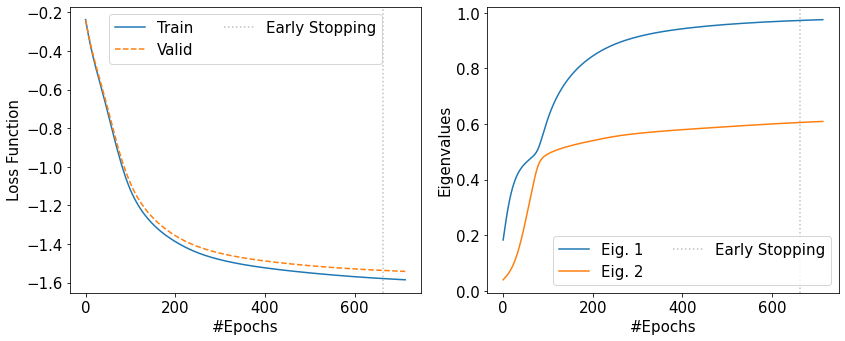

In [14]:
plot_model_lossfunction(model)

Text(0, 0.5, '$\\psi$')

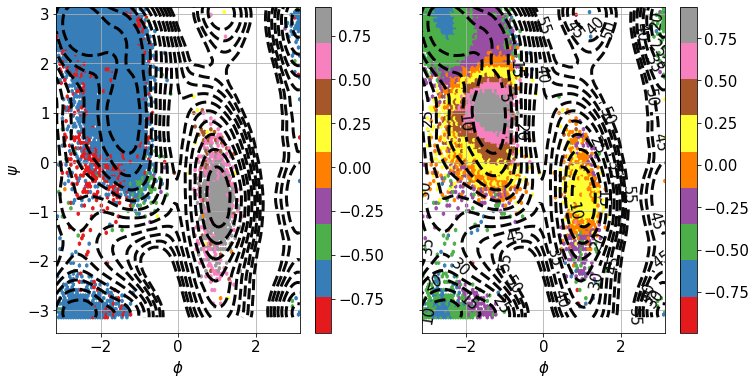

In [15]:
# plot cvs #
fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)

data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]   

data.plot.hexbin(y="psi",x="phi",C="cv1",cmap="Set1",ax=ax[0])
data.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")

# 2

In [16]:
# evaluate tprime
logweight = data["opes.bias"].to_numpy()*sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
'''
rescale_factor = np.mean(np.exp(logweight))
rescale_factor += np.std(np.exp(logweight)) #np.exp(np.max(logweight))
print(rescale_factor)
print(np.std(np.exp(logweight)))
min_lag,max_lag = 1,5 #they must be reweighted in some way
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
lags *= rescale_factor
print(lags)
'''

'\nrescale_factor = np.mean(np.exp(logweight))\nrescale_factor += np.std(np.exp(logweight)) #np.exp(np.max(logweight))\nprint(rescale_factor)\nprint(np.std(np.exp(logweight)))\nmin_lag,max_lag = 1,5 #they must be reweighted in some way\nn = 1 # how many lag times between min and max lag\nlags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation\nlags *= rescale_factor\nprint(lags)\n'

In [17]:
train_datasets = []
valid_datasets = []
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),tprime=tprime,logweights=logweight,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -1.220      -1.176      0.726  0.493  
100   -1.277      -1.202      0.744  0.531  
150   -1.343      -1.262      0.752  0.589  
200   -1.454      -1.392      0.756  0.695  
250   -1.576      -1.544      0.816  0.758  
300   -1.651      -1.626      0.889  0.761  
350   -1.685      -1.660      0.922  0.762  
400   -1.705      -1.679      0.941  0.764  
450   -1.718      -1.690      0.953  0.764  
500   -1.727      -1.696      0.962  0.766  
INFO: Early stopping
527   -1.732      -1.698      0.966  0.766  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

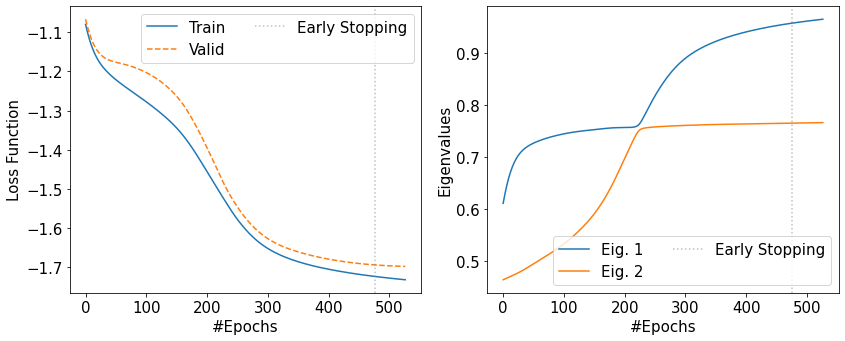

In [18]:
plot_model_lossfunction(model)

Text(0, 0.5, '$\\psi$')

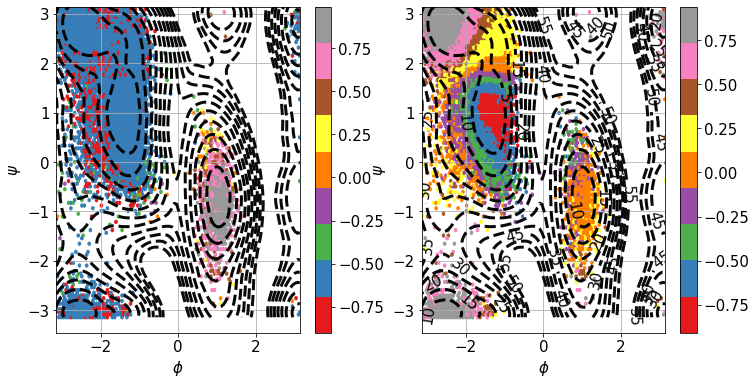

In [19]:
# plot cvs #
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
data.plot.hexbin(y="psi",x="phi",C="cv1",cmap="Set1",ax=ax[0])
data.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")

# 3 

In [20]:
# evaluate tprime
logweight =  (data["opes.bias"].to_numpy()-np.max(data["opes.bias"].to_numpy()) ) *sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
'''
rescale_factor = np.average(np.exp(logweight))
rescale_factor = np.exp(np.max(logweight))
print(rescale_factor)
#print(np.std(np.exp(logweight)))
min_lag,max_lag = 0.5,5 #they must be reweighted in some way
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
lags *= rescale_factor
print(lags)
'''

'\nrescale_factor = np.average(np.exp(logweight))\nrescale_factor = np.exp(np.max(logweight))\nprint(rescale_factor)\n#print(np.std(np.exp(logweight)))\nmin_lag,max_lag = 0.5,5 #they must be reweighted in some way\nn = 1 # how many lag times between min and max lag\nlags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation\nlags *= rescale_factor\nprint(lags)\n'

In [21]:
train_datasets = []
valid_datasets = []
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),tprime=tprime,logweights=logweight,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.691      -0.720      0.433  0.251  
100   -0.997      -1.032      0.511  0.481  
150   -1.199      -1.239      0.690  0.506  
200   -1.307      -1.350      0.783  0.523  
250   -1.364      -1.404      0.831  0.532  
300   -1.401      -1.436      0.861  0.539  
350   -1.428      -1.458      0.883  0.544  
400   -1.448      -1.471      0.899  0.548  
450   -1.465      -1.480      0.913  0.552  
500   -1.480      -1.486      0.924  0.556  
INFO: Early stopping
542   -1.491      -1.489      0.932  0.559  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

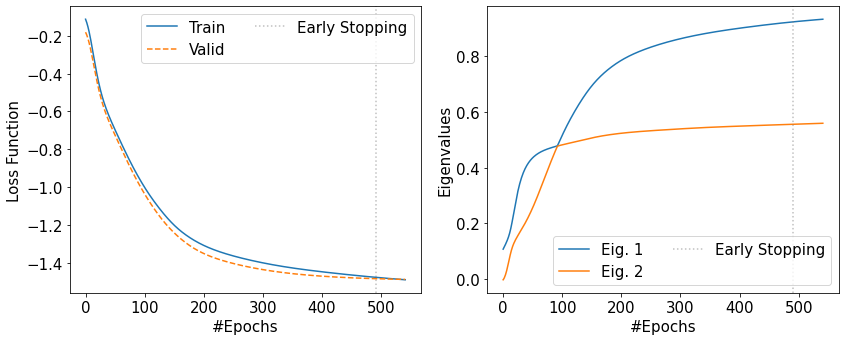

In [22]:
plot_model_lossfunction(model)

Text(0, 0.5, '$\\psi$')

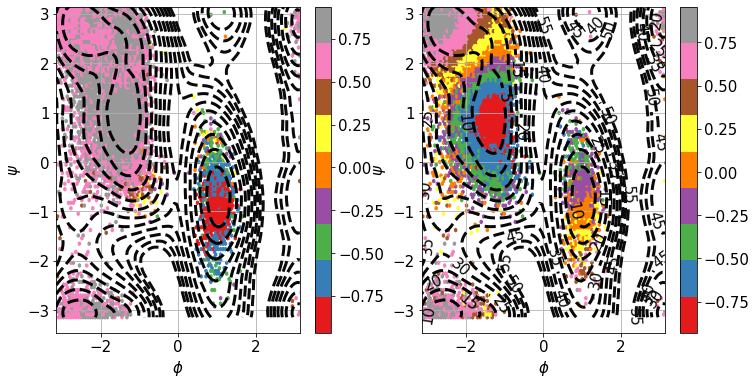

In [23]:
# plot cvs #
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
data.plot.hexbin(y="psi",x="phi",C="cv1",cmap="Set1",ax=ax[0])
data.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")

# 4

In [24]:
# evaluate tprime
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
logweight /= np.abs(min(logweight))
logweight *= sim_parameters["beta"]
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
lags = [1]

In [25]:
train_datasets = []
valid_datasets = []
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,lag_time=np.round(lag,3),tprime=tprime,logweights=logweight,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.005,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.622      -0.619      0.476  0.138  
100   -1.030      -1.020      0.543  0.480  
150   -1.265      -1.230      0.734  0.529  
200   -1.375      -1.328      0.830  0.543  
250   -1.434      -1.381      0.881  0.551  
300   -1.471      -1.414      0.914  0.557  
350   -1.497      -1.435      0.936  0.560  
400   -1.515      -1.449      0.951  0.564  
450   -1.530      -1.460      0.962  0.568  
500   -1.542      -1.468      0.970  0.572  
550   -1.553      -1.475      0.977  0.576  
600   -1.563      -1.482      0.982  0.580  
650   -1.573      -1.489      0.986  0.586  
700   -1.583      -1.495      0.990  0.593  
750   -1.592      -1.500      0.993  0.599  
INFO: Early stopping
789   -1.598      -1.504      0.995  0.603  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

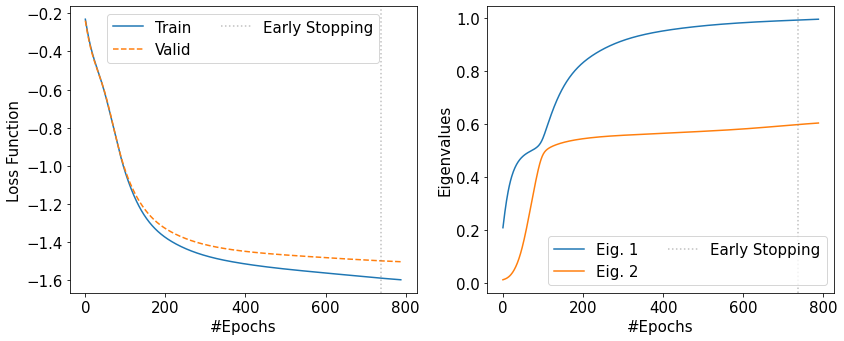

In [26]:
plot_model_lossfunction(model)

Text(0, 0.5, '$\\psi$')

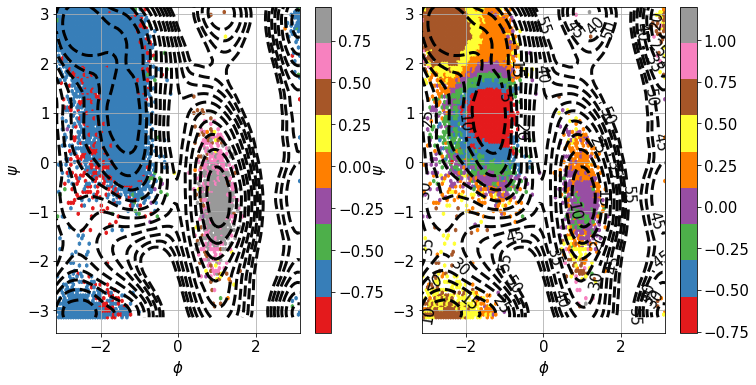

In [27]:
# plot cvs #
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]   

fig,ax = plt.subplots(1,2,figsize=(12,6))
data.plot.hexbin(y="psi",x="phi",C="cv1",cmap="Set1",ax=ax[0])
data.plot.hexbin(y="psi",x="phi",C="cv2",cmap="Set1",ax=ax[1])

fes = np.loadtxt("angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax[0].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c = ax[1].contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax[0].grid()
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\psi$")
ax[1].grid()
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\psi$")

## $\Delta F$

In [28]:
'''
#-- each step is 1ps --#
data = load_dataframe(folder+"COLVAR").filter(regex="^phi").to_numpy()[:]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:]
logweight= (logweight-np.max(logweight))*sim_parameters["beta"]
s = data[:]
weight = np.exp(logweight[:])
fes,grid,bounds,error = compute_fes(s, weights=weight,
                                    temp=sim_parameters["temp"],
                                    kbt=sim_parameters["kbt"],
                                    blocks=2,
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=False)
ind1 = (grid<0) 
ind2 = (grid>0) 
grid1 = grid[ ind1 ]
grid2 = grid[ ind2 ] 
I1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)
I2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)
    
res = (1/sim_parameters["beta"])*np.log(I1/I2)
print(res)
'''

'\n#-- each step is 1ps --#\ndata = load_dataframe(folder+"COLVAR").filter(regex="^phi").to_numpy()[:]\nlogweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:]\nlogweight= (logweight-np.max(logweight))*sim_parameters["beta"]\ns = data[:]\nweight = np.exp(logweight[:])\nfes,grid,bounds,error = compute_fes(s, weights=weight,\n                                    temp=sim_parameters["temp"],\n                                    kbt=sim_parameters["kbt"],\n                                    blocks=2,\n                                    bandwidth=sim_parameters["bandwidth"],scale_by=\'range\',\n                                    plot=False)\nind1 = (grid<0) \nind2 = (grid>0) \ngrid1 = grid[ ind1 ]\ngrid2 = grid[ ind2 ] \nI1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)\nI2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)\n    \nres = (1/sim_parameters["beta"])*np.log(I1/I2)\nprint(res)\n'

In [29]:
'''
#-- each step is 1ps --#
#-- we are interested in the first 10 ns --#
last = 1*1000*10 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^phi").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))*sim_parameters["beta"]
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=100

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) 
    ind2 = (grid>0) 
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]*sim_parameters["beta"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]*sim_parameters["beta"]), grid2)
    
    deltaf = np.append(deltaf,(1/sim_parameters["beta"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.2*kb*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [Kj/mol]")
'''

'\n#-- each step is 1ps --#\n#-- we are interested in the first 10 ns --#\nlast = 1*1000*10 #last ns\ndata = load_dataframe(folder+"COLVAR").filter(regex="^phi").to_numpy()[:last]\nlogweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]\nlogweight= (logweight-np.max(logweight))*sim_parameters["beta"]\n#-- with CLEAR set to 1000 I perform the estimation every ns --#\nCLEAR=100\n\ndeltaf = np.empty(0)\nfor el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):\n    s = data[:el]\n    weight = np.exp(logweight[:el])\n    fes,grid,bounds,error = compute_fes(s, weights=weight,\n                                        temp=sim_parameters["temp"],\n                                        kbt=sim_parameters["kbt"],\n                                        blocks=2,\n                                        bandwidth=sim_parameters["bandwidth"],scale_by=\'range\',\n                                        plot=False)\n    ind1 = (grid<0) \n    ind2 = (gr